In [31]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, sum
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression



In [33]:
spark = SparkSession.builder \
    .appName("CoffeeSalesAnalysis") \
    .config("spark.hadoop.io.nativeio.enabled", "false") \
    .getOrCreate()

In [34]:
file_path = "Coffe_sales.csv" 

df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)


df.show(5)
df.printSchema()

+-----------+---------+-----+-------------+-----------+-------+----------+-----------+---------+----------+--------------------+
|hour_of_day|cash_type|money|  coffee_name|Time_of_Day|Weekday|Month_name|Weekdaysort|Monthsort|      Date|                Time|
+-----------+---------+-----+-------------+-----------+-------+----------+-----------+---------+----------+--------------------+
|         10|     card| 38.7|        Latte|    Morning|    Fri|       Mar|          5|        3|2024-03-01|2025-10-07 10:15:...|
|         12|     card| 38.7|Hot Chocolate|  Afternoon|    Fri|       Mar|          5|        3|2024-03-01|2025-10-07 12:19:...|
|         12|     card| 38.7|Hot Chocolate|  Afternoon|    Fri|       Mar|          5|        3|2024-03-01|2025-10-07 12:20:...|
|         13|     card| 28.9|    Americano|  Afternoon|    Fri|       Mar|          5|        3|2024-03-01|2025-10-07 13:46:...|
|         13|     card| 38.7|        Latte|  Afternoon|    Fri|       Mar|          5|        3|2

In [35]:
print("Total number of sales transactions:", df.count())

Total number of sales transactions: 3547


In [36]:
total_tx = df.count()
print("Total number of transactions:", total_tx)


Total number of transactions: 3547


In [37]:
print(" Distinct coffee types")
df.select("coffee_name").distinct().orderBy("coffee_name").show(truncate=False)



 Distinct coffee types
+-------------------+
|coffee_name        |
+-------------------+
|Americano          |
|Americano with Milk|
|Cappuccino         |
|Cocoa              |
|Cortado            |
|Espresso           |
|Hot Chocolate      |
|Latte              |
+-------------------+



In [38]:
print(" Distinct payment methods (cash_type)")

df.select("cash_type").distinct().show()


 Distinct payment methods (cash_type)
+---------+
|cash_type|
+---------+
|     card|
+---------+



In [39]:
print("Basic statistics for 'money' (transaction amount)")

df.select("money").describe().show()

print("\nMin and Max transaction amount:")
df.agg(min("money").alias("Min"), max("money").alias("Max")).show()

Basic statistics for 'money' (transaction amount)
+-------+------------------+
|summary|             money|
+-------+------------------+
|  count|              3547|
|   mean| 31.64521567521797|
| stddev|4.8777537035910035|
|    min|             18.12|
|    max|              38.7|
+-------+------------------+


Min and Max transaction amount:
+-----+----+
|  Min| Max|
+-----+----+
|18.12|38.7|
+-----+----+



In [40]:
total_revenue = df.agg(F.sum("money").alias("Total_Revenue")).collect()[0]["Total_Revenue"]
avg_spend = df.agg(F.avg("money").alias("Avg_Spend")).collect()[0]["Avg_Spend"]

print(f"Total Revenue: {total_revenue:.2f}")
print(f"Average Spend per Transaction: {avg_spend:.2f}")


Total Revenue: 112245.58
Average Spend per Transaction: 31.65


In [41]:
# ------------------------------
# Sales by Coffee Type & Top sold
# ------------------------------
print("# ------------------------------")
print("# 6. Total sales by coffee type (descending)")
print("# ------------------------------")
df.groupBy("coffee_name").agg(F.sum("money").alias("Total_Sales")) \
  .orderBy(F.desc("Total_Sales")).show(20, truncate=False)

print("\n# ------------------------------")
print("# 7. Top 10 most-ordered coffee types (by count)")
print("# ------------------------------")
df.groupBy("coffee_name").agg(F.count("*").alias("Orders")) \
  .orderBy(F.desc("Orders")).show(10, truncate=False)


# ------------------------------
# 6. Total sales by coffee type (descending)
# ------------------------------
+-------------------+------------------+
|coffee_name        |Total_Sales       |
+-------------------+------------------+
|Latte              |26875.2999999995  |
|Americano with Milk|24751.120000000228|
|Cappuccino         |17439.139999999974|
|Americano          |14650.259999999824|
|Hot Chocolate      |9933.460000000046 |
|Cocoa              |8521.160000000038 |
|Cortado            |7384.86000000001  |
|Espresso           |2690.279999999994 |
+-------------------+------------------+


# ------------------------------
# 7. Top 10 most-ordered coffee types (by count)
# ------------------------------
+-------------------+------+
|coffee_name        |Orders|
+-------------------+------+
|Americano with Milk|809   |
|Latte              |757   |
|Americano          |564   |
|Cappuccino         |486   |
|Cortado            |287   |
|Hot Chocolate      |276   |
|Cocoa             

In [42]:
# ------------------------------
#  Payment method analysis
# ------------------------------
print("# ------------------------------")
print("# 8. Payment method usage and avg spend")
print("# ------------------------------")
df.groupBy("cash_type").agg(
    F.count("*").alias("Transactions"),
    avg("money").alias("Avg_Spend"),
    F.sum("money").alias("Total_Revenue")
).orderBy(F.desc("Transactions")).show(truncate=False)


# ------------------------------
# 8. Payment method usage and avg spend
# ------------------------------
+---------+------------+-----------------+------------------+
|cash_type|Transactions|Avg_Spend        |Total_Revenue     |
+---------+------------+-----------------+------------------+
|card     |3547        |31.64521567521797|112245.57999999814|
+---------+------------+-----------------+------------------+



In [43]:
# ------------------------------
# Time-based analysis (hour, weekday, month)
# ------------------------------
# Ensure correct dtypes
df = df.withColumn("hour_of_day", col("hour_of_day").cast(IntegerType()))
df = df.withColumn("Weekdaysort", col("Weekdaysort").cast(IntegerType()))
df = df.withColumn("Monthsort", col("Monthsort").cast(IntegerType()))
df = df.withColumn("money", col("money").cast(DoubleType()))

print("# ------------------------------")
print("# 9. Hourly sales (total) ordered by hour")
print("# ------------------------------")
df.groupBy("hour_of_day").agg(F.sum("money").alias("Hourly_Sales")) \
  .orderBy("hour_of_day").show(24)

print("\n# ------------------------------")
print("# 10. Top 10 busiest hours by sales")
print("# ------------------------------")
df.groupBy("hour_of_day").agg(F.sum("money").alias("Hourly_Sales")) \
  .orderBy(F.desc("Hourly_Sales")).show(10)

print("\n# ------------------------------")
print("# 11. Sales by Weekday (ordered by Weekdaysort)")
print("# ------------------------------")
df.groupBy("Weekday", "Weekdaysort").agg(F.sum("money").alias("Total_Sales")) \
  .orderBy("Weekdaysort").show()

print("\n# ------------------------------")
print("# 12. Sales by Month (ordered by Monthsort)")
print("# ------------------------------")
df.groupBy("Month_name", "Monthsort").agg(F.sum("money").alias("Monthly_Sales")) \
  .orderBy("Monthsort").show()


# ------------------------------
# 9. Hourly sales (total) ordered by hour
# ------------------------------
+-----------+------------------+
|hour_of_day|      Hourly_Sales|
+-----------+------------------+
|          6|             149.4|
|          7| 2846.020000000003|
|          8| 7017.880000000007|
|          9| 7264.280000000005|
|         10|10198.519999999991|
|         11| 8453.100000000008|
|         12| 7419.620000000012|
|         13| 7028.760000000013|
|         14|7173.8000000000175|
|         15|7476.0200000000195|
|         16| 9031.840000000024|
|         17| 7659.760000000013|
|         18| 7162.600000000018|
|         19|7751.9600000000155|
|         20|5578.9200000000155|
|         21| 6397.940000000017|
|         22| 3635.160000000008|
+-----------+------------------+


# ------------------------------
# 10. Top 10 busiest hours by sales
# ------------------------------
+-----------+------------------+
|hour_of_day|      Hourly_Sales|
+-----------+----------------

In [44]:
# ------------------------------
# Popularity combos & peak hours per Time_of_Day
# ------------------------------
print("# ------------------------------")
print("# 13. Most popular coffee by Time_of_Day (count)")
print("# ------------------------------")
df.groupBy("Time_of_Day", "coffee_name") \
  .agg(F.count("*").alias("Orders")) \
  .orderBy("Time_of_Day", F.desc("Orders")).show(100, truncate=False)

print("\n# ------------------------------")
print("# 14. Peak hour for each Time_of_Day (by revenue)")
print("# ------------------------------")
df.groupBy("Time_of_Day", "hour_of_day") \
  .agg(F.sum("money").alias("Sales")) \
  .orderBy("Time_of_Day",F.desc("Sales")).show(20, truncate=False)


# ------------------------------
# 13. Most popular coffee by Time_of_Day (count)
# ------------------------------
+-----------+-------------------+------+
|Time_of_Day|coffee_name        |Orders|
+-----------+-------------------+------+
|Afternoon  |Latte              |270   |
|Afternoon  |Americano with Milk|239   |
|Afternoon  |Americano          |233   |
|Afternoon  |Cappuccino         |164   |
|Afternoon  |Cortado            |88    |
|Afternoon  |Hot Chocolate      |80    |
|Afternoon  |Cocoa              |75    |
|Afternoon  |Espresso           |56    |
|Morning    |Americano with Milk|331   |
|Morning    |Americano          |219   |
|Morning    |Latte              |215   |
|Morning    |Cortado            |143   |
|Morning    |Cappuccino         |122   |
|Morning    |Cocoa              |58    |
|Morning    |Hot Chocolate      |49    |
|Morning    |Espresso           |44    |
|Night      |Latte              |272   |
|Night      |Americano with Milk|239   |
|Night      |Cappuccino 

In [45]:
# ------------------------------
#  top revenue dates
# ------------------------------

print("\n# ------------------------------")
print("# 16. Top 5 revenue-generating dates")
print("# ------------------------------")
df.groupBy("Date").agg(F.sum("money").alias("Total_Sales")) \
  .orderBy(F.desc("Total_Sales")).show(5, truncate=False)



# ------------------------------
# 16. Top 5 revenue-generating dates
# ------------------------------
+----------+-----------------+
|Date      |Total_Sales      |
+----------+-----------------+
|2024-10-11|836.6599999999999|
|2025-02-03|795.9999999999999|
|2025-02-05|760.24           |
|2025-03-03|737.7199999999999|
|2024-10-17|726.4599999999999|
+----------+-----------------+
only showing top 5 rows


In [46]:
# ------------------------------
#  Aggregation table: Weekday x Time_of_Day
# ------------------------------
print("# ------------------------------")
print("# 17. Aggregation summary: Weekday x Time_of_Day")
print("# ------------------------------")
wk_time = df.groupBy("Weekday", "Time_of_Day", "Weekdaysort").agg(
    F.sum("money").alias("Total_Sales"),
    F.count("*").alias("Total_Orders"),
    avg("money").alias("Avg_Order_Value")
).orderBy("Weekdaysort", "Time_of_Day")

wk_time.show(200, truncate=False)


# ------------------------------
# 17. Aggregation summary: Weekday x Time_of_Day
# ------------------------------
+-------+-----------+-----------+------------------+------------+------------------+
|Weekday|Time_of_Day|Weekdaysort|Total_Sales       |Total_Orders|Avg_Order_Value   |
+-------+-----------+-----------+------------------+------------+------------------+
|Mon    |Afternoon  |1          |5664.100000000017 |177         |32.00056497175151 |
|Mon    |Morning    |1          |5987.340000000008 |193         |31.02248704663217 |
|Mon    |Night      |1          |5711.660000000013 |174         |32.82563218390812 |
|Tue    |Afternoon  |2          |5012.080000000011 |160         |31.32550000000007 |
|Tue    |Morning    |2          |6343.920000000008 |207         |30.64695652173917 |
|Tue    |Night      |2          |6812.38000000002  |205         |33.23112195121961 |
|Wed    |Afternoon  |3          |5147.760000000013 |165         |31.198545454545535|
|Wed    |Morning    |3          |50

In [47]:
# ------------------------------
#  Simple Predictive Model (Linear Regression with PySpark)
# ------------------------------
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

print("# ------------------------------")
print("# 20. Simple Linear Regression: predict 'money' using hour_of_day & Weekdaysort")
print("# ------------------------------")

model_df = df.select("money", "hour_of_day", "Weekdaysort").na.drop()
assembler = VectorAssembler(inputCols=["hour_of_day", "Weekdaysort"], outputCol="features")
model_input = assembler.transform(model_df).select(col("features"), col("money").alias("label"))

train, test = model_input.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

test_summary = lr_model.evaluate(test)
print("\nModel metrics on test set:")
print(f"  RMSE: {test_summary.rootMeanSquaredError:.4f}")
print(f"  R2: {test_summary.r2:.4f}")


# ------------------------------
# 20. Simple Linear Regression: predict 'money' using hour_of_day & Weekdaysort
# ------------------------------
Coefficients: [0.21683445946810442,-0.047101601942334335]
Intercept: 28.68592078697855

Model metrics on test set:
  RMSE: 4.6716
  R2: 0.0588


In [48]:
!python -m pip install --upgrade pip


In [49]:
!pip install pandas


In [50]:
# ------------------------------
# Cell 14 - Prepare pandas data for plotting
# ------------------------------
# Convert required aggregations to pandas for plotting
pdf = df.toPandas()

coffee_sales = pdf.groupby('coffee_name')['money'].sum().sort_values(ascending=False)
hour_sales = pdf.groupby('hour_of_day')['money'].sum().reindex(range(0,24), fill_value=0)
payment_counts = pdf['cash_type'].value_counts()
# Weekday order using Weekdaysort if present
try:
    weekday_order = pdf[['Weekday','Weekdaysort']].drop_duplicates().sort_values('Weekdaysort')['Weekday'].tolist()
    weekday_sales = pdf.groupby('Weekday')['money'].sum().reindex(weekday_order)
except Exception:
    weekday_sales = pdf.groupby('Weekday')['money'].sum()


In [51]:
!pip install matplotlib --user


In [52]:
import sys
!{sys.executable} -m pip install matplotlib


In [53]:
import matplotlib.pyplot as plt


In [54]:
# ------------------------------
#  Prepare pandas data for plotting
# ------------------------------
# Convert required aggregations to pandas for plotting
pdf = df.toPandas()

coffee_sales = pdf.groupby('coffee_name')['money'].sum().sort_values(ascending=False)
hour_sales = pdf.groupby('hour_of_day')['money'].sum().reindex(range(0,24), fill_value=0)
payment_counts = pdf['cash_type'].value_counts()
# Weekday order using Weekdaysort if present
try:
    weekday_order = pdf[['Weekday','Weekdaysort']].drop_duplicates().sort_values('Weekdaysort')['Weekday'].tolist()
    weekday_sales = pdf.groupby('Weekday')['money'].sum().reindex(weekday_order)
except Exception:
    weekday_sales = pdf.groupby('Weekday')['money'].sum()


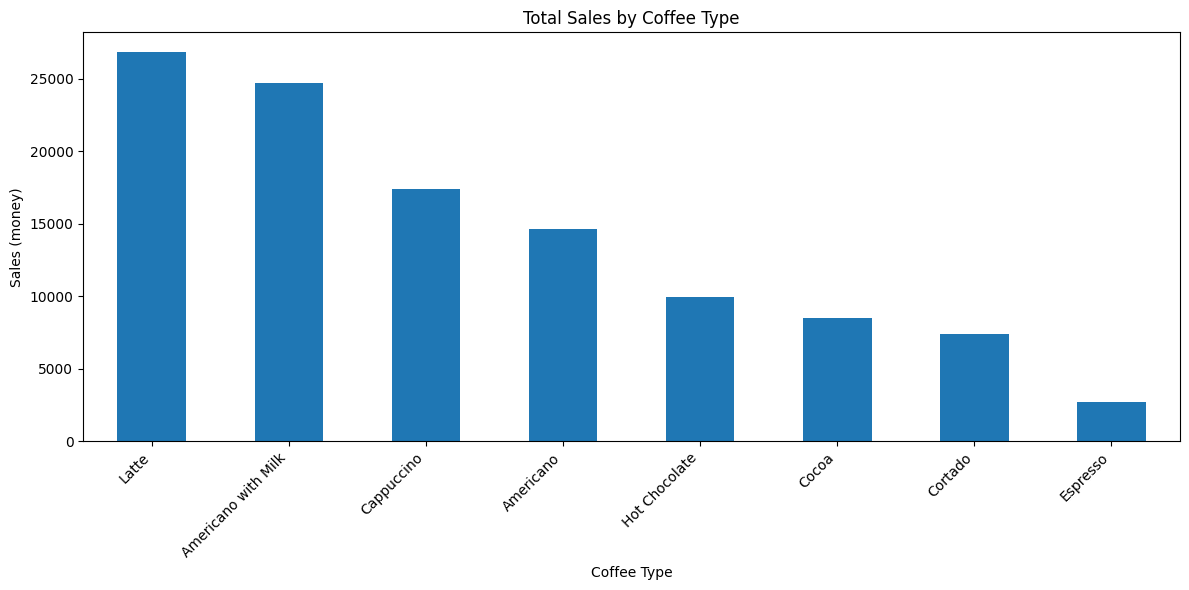

In [55]:
# ------------------------------
#  Plot : Bar - Total Sales by Coffee Type
# ------------------------------
plt.figure(figsize=(12,6))
coffee_sales.plot(kind='bar')
plt.title("Total Sales by Coffee Type")
plt.xlabel("Coffee Type")
plt.ylabel("Sales (money)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


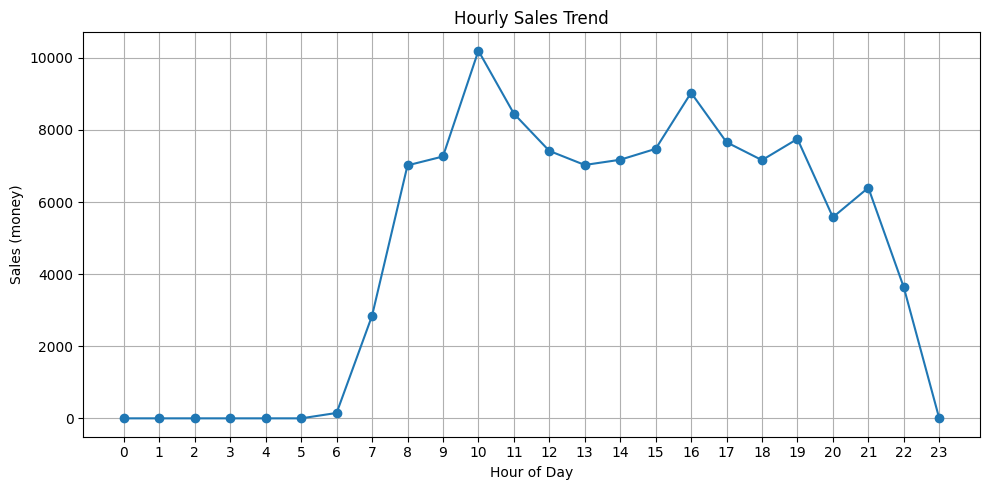

In [56]:
# ------------------------------
# Plot : Line - Hourly Sales Trend
# ------------------------------
plt.figure(figsize=(10,5))
plt.plot(hour_sales.index, hour_sales.values, marker='o')
plt.title("Hourly Sales Trend")
plt.xlabel("Hour of Day")
plt.xticks(range(0,24))
plt.ylabel("Sales (money)")
plt.grid(True)
plt.tight_layout()
plt.show()


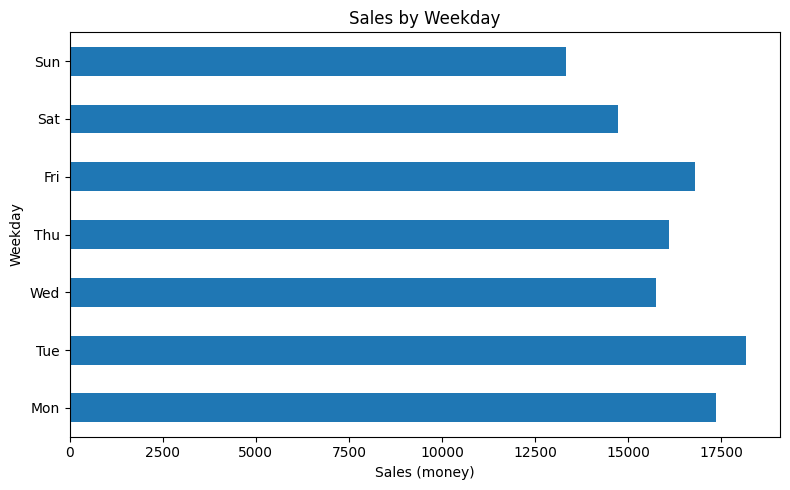

In [57]:
# ------------------------------
# Plot : Barh - Sales by Weekday
# ------------------------------
plt.figure(figsize=(8,5))
weekday_sales.plot(kind='barh')
plt.title("Sales by Weekday")
plt.xlabel("Sales (money)")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


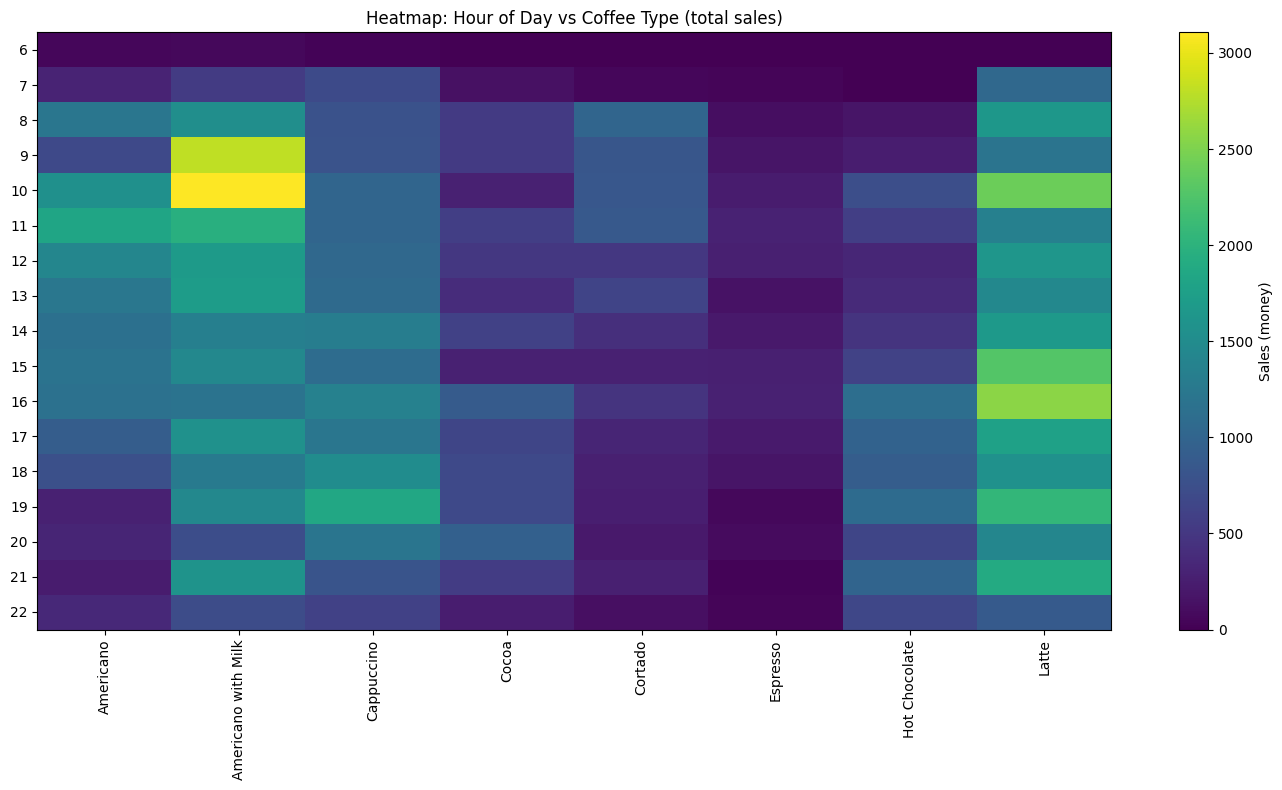

In [58]:
# ------------------------------
#  Heatmap (Hour vs Coffee Type) 
# ------------------------------
pivot = pdf.pivot_table(index='hour_of_day', columns='coffee_name', values='money', aggfunc='sum', fill_value=0)
pivot = pivot.sort_index()
plt.figure(figsize=(14,8))
plt.imshow(pivot.values, aspect='auto', interpolation='nearest')
plt.colorbar(label='Sales (money)')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.title("Heatmap: Hour of Day vs Coffee Type (total sales)")
plt.tight_layout()
plt.show()


In [59]:
# ------------------------------
#  Final Insights & Recommendations 
# ------------------------------
print("\n===== Insights Summary =====")
print(f"Total transactions: {total_tx}")
print(f"Total revenue: {total_revenue:.2f}")
print(f"Average order value: {avg_spend:.2f}\n")

print("Top selling coffees (by revenue):")
print(coffee_sales.head(5).to_string())

print("\nPeak sales hours (top 5):")
print(hour_sales.sort_values(ascending=False).head(5).to_string())

print("\nTop payment methods by usage:")
print(payment_counts.to_string())

print("\nModel summary (simple LR predicting money from hour_of_day & weekday):")
print(f"  Test R2: {test_summary.r2:.4f}, RMSE: {test_summary.rootMeanSquaredError:.4f}\n")

print("Recommendations:")
print(" - Run promotions during peak hours to increase average basket size.")
print(" - Introduce bundle offers on top-selling coffees.")
print(" - Explore payment promotions for payment types that show higher average spend.")



===== Insights Summary =====
Total transactions: 3547
Total revenue: 112245.58
Average order value: 31.65

Top selling coffees (by revenue):
coffee_name
Latte                  26875.30
Americano with Milk    24751.12
Cappuccino             17439.14
Americano              14650.26
Hot Chocolate           9933.46

Peak sales hours (top 5):
hour_of_day
10    10198.52
16     9031.84
11     8453.10
19     7751.96
17     7659.76

Top payment methods by usage:
cash_type
card    3547

Model summary (simple LR predicting money from hour_of_day & weekday):
  Test R2: 0.0588, RMSE: 4.6716

Recommendations:
 - Run promotions during peak hours to increase average basket size.
 - Introduce bundle offers on top-selling coffees.
 - Explore payment promotions for payment types that show higher average spend.
